In [1]:
import os
os.chdir(os.pardir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

#Styling Block
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 26
FIG_SIZE = (12,6) #change figure size throughout for non-faceted figures
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style('white')
cp = sns.color_palette() #color palette to use throughout 

In [2]:
country = 'india'
scenario = 'base'
results_path = os.path.join('runs', 'results_20201125_095552')

results = pd.read_csv(os.path.join(results_path,'india_base','agent_outputs.csv'))
results.rename({'metric_value':'payback_period'}, axis='columns', inplace=True)
results.head()

agent_id state_name sector_abbr  geo_sector_n_agents  \
0         0   nagaland         ind                   61   
1         1   nagaland         ind                   61   
2         2   nagaland         ind                   61   
3         3   nagaland         ind                   61   
4         4   nagaland         ind                   61   

   owner_occupancy_status  developable_buildings_pct  cap_cost_multiplier  \
0                       1                          1                    1   
1                       1                          1                    1   
2                       1                          1                    1   
3                       1                          1                    1   
4                       1                          1                    1   

  district_name  developable_roof_sqft  load_per_customer_in_bin_kwh_initial  \
0       dimapur           20328.366408                         117385.021289   
1       dimapur            1516.955000                          12073.426875   
2       dimapur           14370.149302                           5491.452224   
3       dimapur           25241.965111                          91057.122685   
4       dimapur            9000.749102                          55953.257881   

   ...  new_batt_kw  new_batt_kwh  number_of_adopters  market_value  \
0  ...          0.0           0.0            0.002647    348.476360   
1  ...          0.0           0.0            0.015000    203.104180   
2  ...          0.0           0.0            0.015882     97.813568   
3  ...          0.0           0.0            0.011471   1171.376911   
4  ...          0.0           0.0            0.039706   2491.594001   

   pv_kw_cum batt_kw_cum  batt_kwh_cum total_gen_twh index  \
0   0.212748         0.0           0.0  3.107268e-07     0   
1   0.123997         0.0           0.0  1.811024e-07     1   
2   0.059716         0.0           0.0  8.721767e-08     2   
3   0.715136         0.0           0.0  1.044485e-06     3   
4   1.521141         0.0           0.0  2.221686e-06     4   

  max_market_share_last_year  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  

[5 rows x 115 columns]

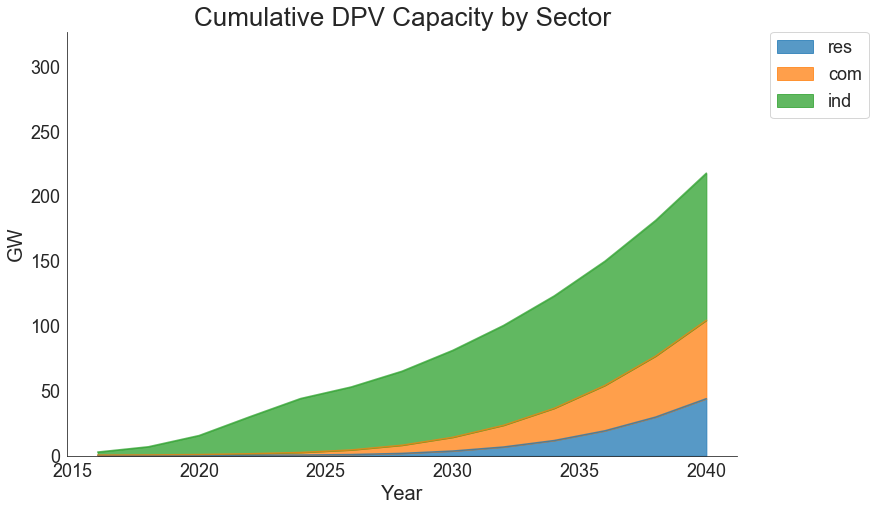

In [3]:
data = results.copy()
data['pv_GW_cum'] = data['pv_kw_cum'] / 1e6
deployment = data.groupby(['year','sector_abbr'])['pv_GW_cum'].sum().reset_index()
deployment = deployment.pivot(index='year', columns='sector_abbr', values='pv_GW_cum')

df = deployment[['res','com','ind']]

fig, ax = plt.subplots(figsize=(FIG_SIZE[0], FIG_SIZE[1]*1.3))
df.plot.area(ax=ax, alpha=0.75)

# --- Readjust ylim ---
ax.set_ylim((0, max(list(deployment.sum(axis=1))) * 1.5))

ax.set_title(f'Cumulative DPV Capacity by Sector')
ax.set_ylabel('GW')
ax.set_xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine(fig)

Text(0.5, 0, 'Payback Period')

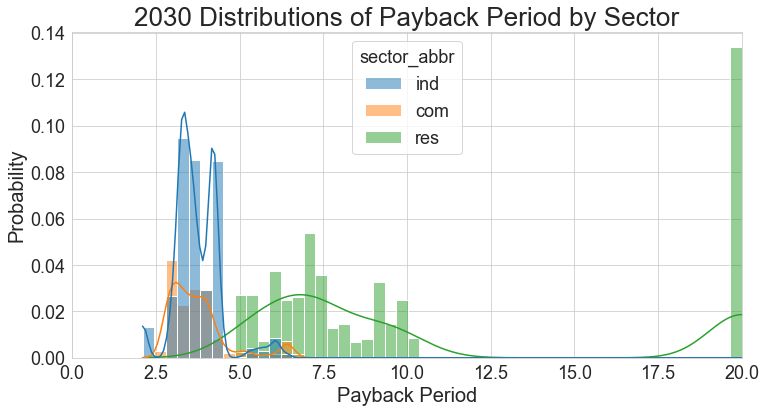

In [4]:
# --- HISTOGRAM OF PAYBACK IN 2030---
sns.set_style('whitegrid')

data_2030 = results.loc[results['year'] == 2030]

fig, ax = plt.subplots(figsize=FIG_SIZE)
sns.histplot(data_2030, x="payback_period", hue='sector_abbr', stat='probability', kde=True, ax=ax)

ax.set_xlim(0,20)
ax.set_title('2030 Distributions of Payback Period by Sector')
ax.set_xlabel('Payback Period')

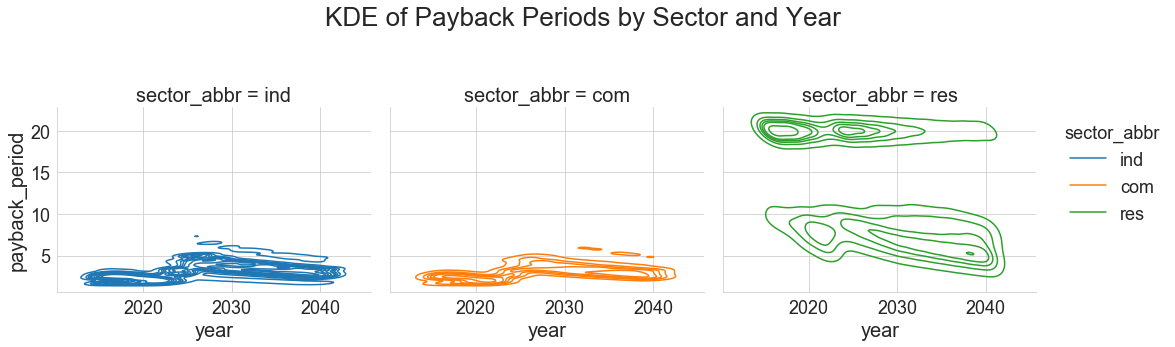

In [5]:
# --- KDE PLOT OF PAYBACK PERIODS BY YEAR ---
g = sns.displot(
    data=results,
    x='year', y='payback_period',
    col='sector_abbr', hue='sector_abbr',
    kind='kde'
)

g.fig.suptitle('KDE of Payback Periods by Sector and Year')
g.fig.subplots_adjust(top=.7)

In [6]:
results.loc[results['state_name']=='karnataka']\
    .groupby(['year'])['pv_kw_cum'].sum() / 1000

year
2016      201.820112
2018      439.549026
2020      968.981252
2022     1950.323517
2024     3068.402572
2026     3595.742817
2028     4327.131685
2030     5380.600233
2032     6830.299349
2034     8882.466802
2036    11460.090006
2038    14463.975628
2040    17747.331628
Name: pv_kw_cum, dtype: float64

In [57]:
# --- PIVOT of ADOPTION BY DISTRICT AND SECTOR ---
pivot = results.pivot_table(
    index=['state_name','district_name','sector_abbr'],
    columns='year',
    values='pv_kw_cum',
    aggfunc='sum',
    margins=True
)

pivot = pivot / 1000 #kW to MW
pivot.reset_index(inplace=True)
pivot.drop('All', axis='columns', inplace=True)

pivot.to_csv(f"{results_path}_dpv_MW_cum.csv")
pivot.head()

year               state_name         district_name sector_abbr      2016  \
0     andaman_nicobar_islands              nicobars         com  0.001052   
1     andaman_nicobar_islands              nicobars         ind  0.001729   
2     andaman_nicobar_islands              nicobars         res  0.000000   
3     andaman_nicobar_islands  north_middle_andaman         com  0.002359   
4     andaman_nicobar_islands  north_middle_andaman         ind  0.002477   

year      2018      2020      2022      2024      2026      2028      2030  \
0     0.003146  0.007354  0.015552  0.031031  0.060324  0.115526  0.217284   
1     0.006197  0.017546  0.045578  0.112245  0.258994  0.540751  0.985874   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.007057  0.016528  0.034979  0.069926  0.136061  0.261078  0.491532   
4     0.008876  0.025156  0.065367  0.161145  0.371973  0.777378  1.417842   

year      2032      2034      2036      2038      2040  
0     0.401234  0.722895  1.260394  2.100442  3.319443  
1     1.520743  2.012079  2.398180  2.685020  2.906919  
2     0.000000  0.000000  0.053518  0.143905  0.296666  
3     0.909408  1.640119  2.864875  4.779030  7.565113  
4     2.188607  2.896637  3.453866  3.867839  4.188573

In [58]:
scenario_folder = os.path.join('input_scenarios',f"{country}_{scenario}")

# --- load by sector ---
load_profile = pd.read_json(os.path.join(scenario_folder, 'normalized_load.json'))

# --- cumulative load by year / sector ---
merged = results.groupby(['state_id','state_name','district_id','district_name','sector_abbr','year'], as_index=False)[['load_in_bin_kwh', 'pv_kw_cum','tilt']].sum()

# --- denormalize load ---
merged = merged.merge(load_profile, on='sector_abbr')
denormalize = lambda x: np.array(x['kwh']) * (x['load_in_bin_kwh'] / sum(x['kwh']))
merged['kwh_denormed'] = merged.apply(denormalize, axis=1)
merged

# # --- load solar by district ---
descale = lambda x: np.array(x) / 1e3
solar_cf = pd.read_json(os.path.join(scenario_folder, 'solar_resource_hourly.json'))
solar_cf['cf'] = solar_cf['cf'].apply(descale)
merged = merged.merge(solar_cf, on=['district_id', 'tilt'])

# # --- calculate generation by district ---
scale_solar = lambda x: np.array(x['cf']) * np.array(x['pv_kw_cum'])
merged['solar_gen'] = merged.apply(scale_solar, axis=1)

# # --- calculate net load by district ---
calc_net_load = lambda x: x['kwh_denormed'] - x['solar_gen']
merged['net_load_profile'] = merged.apply(calc_net_load, axis=1)

# --- iteratively combine districts with multiple sectors ---
unique_dicts = merged[['state_name','district_name','year']].drop_duplicates().to_dict('records')
for index, d in enumerate(unique_dicts):
    state_mask = (merged['state_name'] == d['state_name'])
    district_mask = (merged['district_name'] == d['district_name'])
    year_mask = (merged['year'] == d['year'])
    subset = merged.loc[state_mask & district_mask & year_mask]
    profiles = list(subset['net_load_profile'])
    cum_net_load = np.sum(profiles, axis=0)
    unique_dicts[index]['net_load_kwh_8760'] = cum_net_load
    unique_dicts[index]['net_load_kwh_cum'] = cum_net_load.sum()
    unique_dicts[index]['pv_kw_cum'] = subset['pv_kw_cum'].sum()
    
net_load = pd.DataFrame(unique_dicts)
net_load.to_csv(f"{results_path}_dpv_net_load.csv")
